In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import random 
from datetime import datetime
import pandas as pd
import os 

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/utils/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/utils/')
from exp_hp import get_hp
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results, adjust_spines
from dataprep_utils import get_testing
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/interpret/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/interpret/')
from Gordon_interp import getoutputvecs, confvacc, iconfcorr


# import importlib
# importlib.reload(sys.modules["Gordon_interp"])
# from Gordon_interp import getoutputvecs, confvacc, iconfcorr
# importlib.reload(sys.modules["trainGordon_utils"])
# from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

2023-12-14 14:35:04.074561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 14:35:04.283570: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Functions

In [2]:
def days_in_year(Ytrain):
    _DAYS_IN_MONTH = [31,28,31,30,31,30,31,31,30,31,30,31]  # Ignores leap days.
    start_year, end_year = int(Ytrain.time.dt.year[0]), int(Ytrain.time.dt.year[-1])+1
    dates = []
    for year in range(start_year, end_year):
        for month in range(1, 13):
            for day in range(1, _DAYS_IN_MONTH[month-1]+1):
                dates.append(datetime(year, month, day, hour=0, minute=0))
                
    dates = pd.to_datetime(dates)
    dates_a2a = dates[119:(36500+119)]
    return dates,dates_a2a

In [5]:
MODEL_DIR = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/doy_models/' #models/'
# MODEL_DIR = '/glade/scratch/wchapman/ENSOmjo_ML_models/saved_models/'
EXP_NAME = 'default'
hps = get_hp(EXP_NAME)
# variables:
DROPOUT_RATE = hps['DROPOUT_RATE']

MODELNAME1 = 'ENSO'
RIDGE1 = hps['RIDGE1']
HIDDENS1 = hps['HIDDENS1']

MODELNAME2 = 'MJO'
RIDGE2 = hps['RIDGE2']
HIDDENS2 = hps['HIDDENS2']

BATCH_SIZE = hps['BATCH_SIZE']
N_EPOCHS = 10000
PATIENCE = hps['PATIENCE'] # number of epochs of no "improvement" before training is stopped
LR = hps['LR'] # learning rate


LEADS = [5,7,14,21,28] #np.arange(5,31)
AVGS = np.arange(2,29) 
SEEDS = np.arange(1,6)

SAVE = True

In [6]:
# Check DOY distribution of confident predictions
params={'XVARS':['TS_SST_ONI_45','RMM1_CESM2','RMM2_CESM2']}
N_days_100yrs = 100*365 #days
N_daysbefore =15 #days to go "back in time" for X
x_months = [11,12,1,2]
DIR = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data_for_KJM/'
X2_FINAME='MJO_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
X2VAR1 = params['XVARS'][1]
X2VAR2 = params['XVARS'][2]


for l in LEADS:
    print('LEAD: '+str(l)) 
    
    for a in AVGS:
        print('AVG: '+str(a))
        ddir_save = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data/doy_interpret/'
        finame_doycorr = 'doycorr_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
        
        if not os.path.isfile(ddir_save+finame_doycorr):
            X1test, X2test, Ytest = get_testing(N_z500runmean=a,
                                                LEAD=l)

            INPUT_SHAPE1 = np.shape(X1test)[1:][0]
            INPUT_SHAPE2 = np.shape(X2test)[1:][0]

            ### GET DOY: ROUNDED_INTS ####################################################################
            X2trainRMM1 = xr.open_dataset(DIR+X2_FINAME)[X2VAR1][:N_days_100yrs]
            X2trainRMM2 = xr.open_dataset(DIR+X2_FINAME)[X2VAR2][:N_days_100yrs]
            X2train = xr.concat([X2trainRMM1,X2trainRMM2], dim = 'new_dim') # 2xtime

            X2train_final = X2train[:,:-(a-1)][:,:-1*l] 

            X2mean = X2train_final.groupby('time.dayofyear').mean()
            X2std = X2train_final.groupby('time.dayofyear').std()
            X2train_norm = (X2train_final.groupby('time.dayofyear')- X2mean).groupby('time.dayofyear')/(X2std)

            Xtrain_time = X2train_norm.time
            X2_train = X2train_norm.T.values

            for ee,num in enumerate(reversed(range(N_daysbefore + 1))):
                X2_train_back = X2_train[num:-(ee+1),:]
                if ee==0:
                    X2_train_norm_mem=X2_train[num:-(ee+1),:]
                else:
                    X2_train_norm_mem = np.concatenate([X2_train_back,X2_train_norm_mem],axis=1)

            Xtrain_time_mem = Xtrain_time[:-(N_daysbefore+1)]
            X2_trainxr_mem = xr.DataArray(data=X2_train_norm_mem,
                                    dims=["time","leadx2"],
                                    coords={'time':Xtrain_time_mem, 'leadx2':np.arange(0,(N_daysbefore+1)*2)})

            X2_trainxr_mem_NDJF = X2_trainxr_mem[X2_trainxr_mem.time.dt.month.isin(x_months)]

            vals_doy_train = np.array(X2_trainxr_mem_NDJF['time.dayofyear'])
            vals_doy_train[vals_doy_train<60]+=366
            vals_doy_train_m=np.mean(vals_doy_train)
            vals_doy_train_s=np.std(vals_doy_train)
            rounded_ints = (X2test[:, 32] * vals_doy_train_s + vals_doy_train_m).round().astype(int)
            ###############################################################################################
            
            corr_doy = []
            confcorr_doy = []

            for s in SEEDS:
                # ENSO MODEL
                model1, input1 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE1,
                                             HIDDENS1,
                                             INPUT_SHAPE1,
                                             MODELNAME1)
                # MJO MODEL
                model2, input2 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE2,
                                             HIDDENS2,
                                             INPUT_SHAPE2,
                                             MODELNAME2)   
                # COMBINE ENSO & MJO MODEL
                model = fullmodel(model1, model2,
                                  input1, input2,
                                  s)

                MODEL_FINAME = 'DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
                model.load_weights(MODEL_DIR+MODEL_FINAME)

                model_rawpreds = model.predict((X1test,X2test))                

                conf    = np.max(model_rawpreds,axis=-1)
                predval = np.argmax(model_rawpreds,axis=-1)

                # ------- confident predictions --------------------------------------------------------
                per = 80
                conf_thresh = np.percentile(conf,q=per)
                # -------- confident [i_conf_predval] --------
                i_conf_predval = np.where(conf > conf_thresh)[0]

                # ----- model contribution: ------------------------------------------------------------
                # model1_rawpreds, model2_rawpreds = getoutputvecs(model,
                #                                                        model1,
                #                                                        model2,
                #                                                        X1test,
                #                                                        X2test)
                # # model X winning class (model X output * weight)
                # model1pred = np.argmax(model1_rawpreds,axis=1)
                # model2pred = np.argmax(model2_rawpreds,axis=1)

                # Final model correct:
                i_model_corr = predval==Ytest

                # Where ENSO/MJO/final model (model 1/model 2/total) are correct & confident
                i_model_confcorr  = predval[i_conf_predval]==Ytest[i_conf_predval]
                # i_model1_confcorr = model1pred[i_conf_predval]==Ytest[i_conf_predval]
                # i_model2_confcorr = model2pred[i_conf_predval]==Ytest[i_conf_predval]


                # when MJO or ENSO model is correct (total network doesn't need to be correct):
                # i_model1only_confcorr = model1pred[i_conf_predval] == predval[i_conf_predval]
                # i_model2only_confcorr = model2pred[i_conf_predval] == predval[i_conf_predval]

                # e.g. model1 correct but not model2 and total model correct
                # i_model1_notmodel2_confcorr = (predval[i_conf_predval]==Ytest[i_conf_predval])&(model1pred[i_conf_predval]==Ytest[i_conf_predval]) & (model2pred[i_conf_predval]!=Ytest[i_conf_predval])
                # i_model2_notmodel1_confcorr = (predval[i_conf_predval]==Ytest[i_conf_predval])&(model2pred[i_conf_predval]==Ytest[i_conf_predval]) & (model1pred[i_conf_predval]!=Ytest[i_conf_predval])



                corr_doy.extend(rounded_ints[i_model_corr])
                confcorr_doy.extend(rounded_ints[i_conf_predval][i_model_confcorr])


            if SAVE:
                print('saving')
                
                ddir_save = '/glade/derecho/scratch/kjmayer/DATA/ENSOvsMJO/data/doy_interpret/'
                finame_doycorr = 'doycorr_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_doycorr, corr_doy)
                finame_doyconfcorr = 'doyconfcorr_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_doyconfcorr, confcorr_doy)


LEAD: 5
AVG: 2
AVG: 3
363/363 [==============================] - 0s 912us/step
saving
AVG: 4
361/361 [==============================] - 1s 1ms/step
saving
AVG: 5
363/363 [==============================] - 0s 914us/step
saving
AVG: 6
362/362 [==============================] - 1s 1ms/step
saving
AVG: 7
AVG: 8
362/362 [==============================] - 0s 852us/step
saving
AVG: 9
360/360 [==============================] - 0s 853us/step
saving
AVG: 10
359/359 [==============================] - 0s 908us/step
saving
AVG: 11
357/357 [==============================] - 1s 1ms/step
saving
AVG: 12
358/358 [==============================] - 0s 917us/step
saving
AVG: 13
359/359 [==============================] - 0s 853us/step
saving
AVG: 14
AVG: 15
360/360 [==============================] - 0s 852us/step
saving
AVG: 16
358/358 [==============================] - 1s 1ms/step
saving
AVG: 17
358/358 [==============================] - 0s 842us/step
saving
AVG: 18
359/359 [==============================]

## Plot

In [ ]:
iname_doycorr = 'doycorr_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
check_corr_doy = np.load(ddir_save+finame_doycorr)
finame_doyconfcorr = 'doyconfcorr_DOY_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
check_confcorr_doy = np.load(ddir_save+finame_doyconfcorr)

In [ ]:
# dtsdoing = pd.date_range(start='11-01-2000',end='02-28-2001')
alldts = pd.date_range(start='11-01-2000',end='02-28-2001')
labsy = pd.date_range(start='11-01-2000',end='02-28-2001',freq='MS')
labsy_doy  = np.array(labsy.dayofyear)
labsy_doy[labsy_doy<60]+=366

# labsy=[]
# for dd in dtsdoing[np.arange(305,425,11)-305]:
#     labsy.append(str(dd)[5:10])
fig = plt.figure(figsize=(8,6))
ax = fig.subplot_mosaic('''
                        A
                        ''') 
adjust_spines(ax['A'], ['left', 'bottom'])
ax['A'].spines['top'].set_color('none')
ax['A'].spines['right'].set_color('none')
ax['A'].spines['left'].set_color('dimgrey')
ax['A'].spines['bottom'].set_color('dimgrey')
ax['A'].spines['left'].set_linewidth(2)
ax['A'].spines['bottom'].set_linewidth(2)

plt.hist(rounded_ints[i_model_corr],histtype='step',linewidth=3,density=True,alpha=0.7,bins=17,color='xkcd:grey',label='Correct')
plt.hist(rounded_ints[i_conf_predval][i_model_confcorr],histtype='step',linewidth=3,density=True,alpha=0.4,bins=17,color='xkcd:darkblue',label='Correct \& Confident')
plt.grid(True,alpha=0.1)

plt.title('Network Predictions by DOY',color='dimgrey',loc='left')
plt.legend(fontsize=12,frameon=False,loc='upper left')

# current_yticks, current_yticklabels = plt.yticks()

ax['A'].set_ylabel('Frequency',color='dimgrey')
ax['A'].set_xlabel('Day of Year (DOY)',color='dimgrey')
ax['A'].tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax['A'].set_xticks(labsy_doy,['November','December','January','February'],rotation=0,fontsize=14,color='dimgrey')
ax['A'].set_yticks(np.arange(0.,0.02,0.002), np.round(np.arange(0.,0.02,0.002),3),fontsize=14,color='dimgrey')
# plt.savefig('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/plots/doy_main_final.png',dpi=300,bbox_inches='tight')
plt.show()



### Other plots:

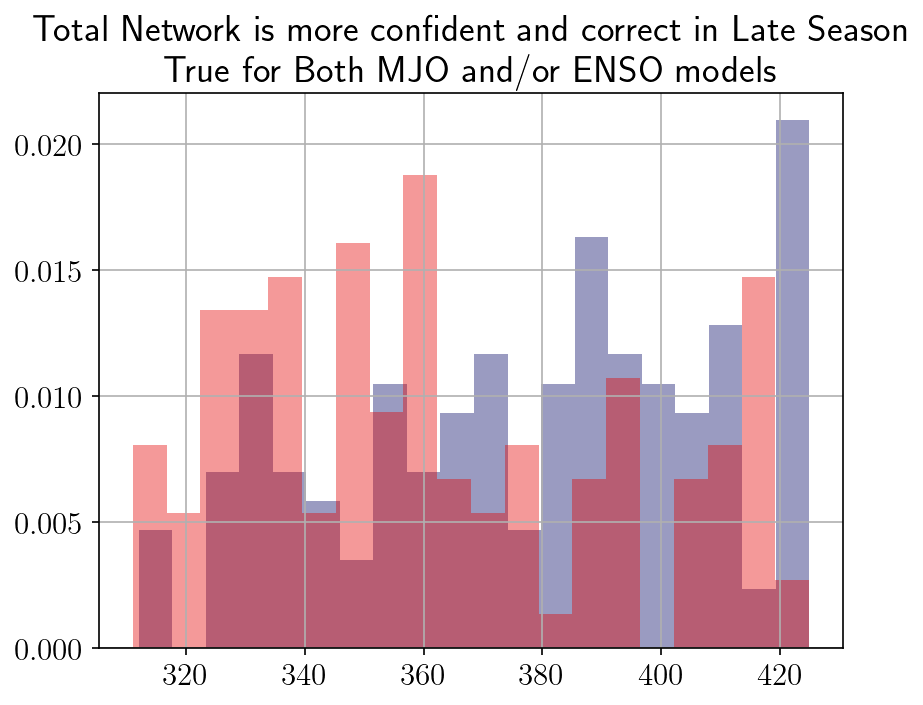

In [279]:
plt.hist(rounded_ints[i_conf_predval[i_model1_notmodel2_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:darkblue')
plt.hist(rounded_ints[i_conf_predval[i_model2_notmodel1_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:red')

# plt.hist(rounded_ints[indx_conf_corr_m1],density=True,alpha=0.4,bins=20,color='xkcd:teal')
# plt.hist(rounded_ints[indx_conf_corr_m2],density=True,alpha=0.4,bins=20,color='xkcd:teal')

# plt.hist(rounded_ints[indx_corr],density=True,alpha=0.7,bins=20,color='xkcd:grey')
plt.grid(True)
plt.title('Total Network is more confident and correct in Late Season\n True for Both MJO and/or ENSO models')
plt.show()

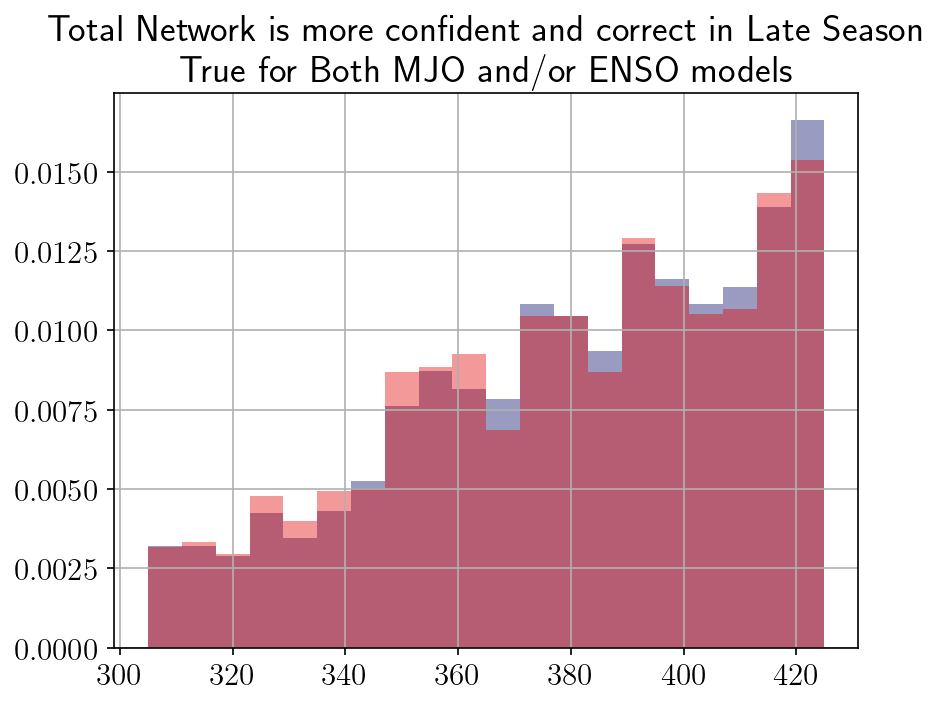

In [280]:
plt.hist(rounded_ints[i_conf_predval[i_model1only_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:darkblue')
plt.hist(rounded_ints[i_conf_predval[i_model2only_confcorr]],density=True,alpha=0.4,bins=20,color='xkcd:red')

# plt.hist(rounded_ints[indx_conf_corr_m1],density=True,alpha=0.4,bins=20,color='xkcd:teal')
# plt.hist(rounded_ints[indx_conf_corr_m2],density=True,alpha=0.4,bins=20,color='xkcd:teal')

# plt.hist(rounded_ints[indx_corr],density=True,alpha=0.7,bins=20,color='xkcd:grey')
plt.grid(True)
plt.title('Total Network is more confident and correct in Late Season\n True for Both MJO and/or ENSO models')
plt.show()